# Stress test gpu-memleak-trace trace

In this experiment, we perform the following actions:
- Create a Python script that spams malloc/free events on the GPU server
- Run gpu-memleak-trace to capture those events
- Check and analyze the tool’s performance when handling high-throughput data (using script/pid_monitor_csv.py to export metrics of the trace process PID)

## Envinroment

```sh
root@gpu1 ~/g/script (dev)# ./basic-info.sh 
==============================
 🖥️  System & Kernel Info
==============================
Linux 6.11.0-26-generic #26~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Apr 17 19:20:47 UTC 2 x86_64 x86_64 x86_64 GNU/Linux

Operating System: Ubuntu 24.04.2 LTS
          Kernel: Linux 6.11.0-26-generic
    Architecture: x86-64
 Hardware Vendor: ASUSTeK COMPUTER INC.
  Hardware Model: ROG STRIX X570-F GAMING
Firmware Version: 5031
   Firmware Date: Mon 2025-01-13
    Firmware Age: 7month 4w

==============================
 📦 Distribution Info
==============================
PRETTY_NAME="Ubuntu 24.04.2 LTS"
NAME="Ubuntu"
VERSION_ID="24.04"
VERSION="24.04.2 LTS (Noble Numbat)"
VERSION_CODENAME=noble
ID=ubuntu
ID_LIKE=debian
UBUNTU_CODENAME=noble

==============================
 💾 Hardware Info
==============================
Architecture:                         x86_64
CPU(s):                               32
On-line CPU(s) list:                  0-31
Model name:                           AMD Ryzen 9 5950X 16-Core Processor
BIOS Model name:                      AMD Ryzen 9 5950X 16-Core Processor             Unknown CPU @ 3.4GHz
Thread(s) per core:                   2
Socket(s):                            1
CPU(s) scaling MHz:                   28%
NUMA node0 CPU(s):                    0-31

               total        used        free      shared  buff/cache   available
Mem:           125Gi        78Gi        47Gi        25Mi       2.2Gi        47Gi
Swap:           27Gi        20Gi       7.5Gi

Filesystem                                        Size  Used Avail Use% Mounted on
total                                              93T  1.6T   92T   2% -

==============================
 🎮 GPU Info
==============================
[NVIDIA GPUs detected]
GPU 0: NVIDIA GeForce RTX 5090 (UUID: GPU-47def375-4603-e5fa-82d3-c7cddc81e65a)

0, NVIDIA GeForce RTX 5090, 570.133.07, 32607, 4492, 27620, 0
```

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Run stressor
To validate and benchmark the tracing system, we generated synthetic GPU memory allocation/free events using the stressor script.

In the eBPF program, we declare a ring buffer with a capacity of 16 MB to handle the data.

```sh
python gpu_stressor.py --throughput 4000 --allocate-size 2048 --ratio 1.0
Running GPU stress generator: 4000 events/sec, alloc_size=2048 bytes, free ratio=1.0

```

## Run monitor

Monitor CPU, Memory, DISK I/O by per PID and then export sample as CSV format
```sh
python pid_mon.py --pids <PID> --interval 0.2 --output=../sample/spammer.csv

2025-09-11 16:42:32,2746692,gpu-memleak-trace,0.0,89.1,0.1,50.9,0.0
2025-09-11 16:42:32,2746692,gpu-memleak-trace,0.0,89.1,0.1,50.9,0.0
2025-09-11 16:42:32,2746692,gpu-memleak-trace,0.0,89.1,0.1,50.9,0.0
2025-09-11 16:42:33,2746692,gpu-memleak-trace,0.0,89.1,0.1,50.9,0.0
2025-09-11 16:42:33,2746692,gpu-memleak-trace,0.0,89.1,0.1,50.9,0.0
2025-09-11 16:42:33,2746692,gpu-memleak-trace,0.0,89.1,0.1,50.9,0.0
2025-09-11 16:42:33,2746692,gpu-memleak-trace,0.0,89.1,0.1,50.9,0.0
```

## Process sample

In [22]:
from datetime import datetime
ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
df = pd.read_csv('../sample/metrics.csv', parse_dates=["timestamp"]).query("name=='gpu-memleak-trace'")
df.head()

,timestamp,description,pid,name,cpu_percent,memory_mb,memory_percent,disk_read_kb,disk_write_kb
1,2025-09-15 17:01:05.038128,--throughput 1000 --allocate-size 2048 --free-...,1258836,gpu-memleak-trace,5.0,80.3,0.1,50.9,0.0
3,2025-09-15 17:01:05.439754,--throughput 1000 --allocate-size 2048 --free-...,1258836,gpu-memleak-trace,10.0,80.8,0.1,50.9,0.0
5,2025-09-15 17:01:05.840861,--throughput 1000 --allocate-size 2048 --free-...,1258836,gpu-memleak-trace,10.0,80.8,0.1,50.9,0.0
7,2025-09-15 17:01:06.241972,--throughput 1000 --allocate-size 2048 --free-...,1258836,gpu-memleak-trace,10.0,80.8,0.1,50.9,0.0
9,2025-09-15 17:01:06.643099,--throughput 1000 --allocate-size 2048 --free-...,1258836,gpu-memleak-trace,5.0,80.8,0.1,50.9,0.0


pid      name               description                                                                      
1258836  gpu-memleak-trace  --throughput 1000 --allocate-size 2048 --free-ratio 1.0                              Axes(0.125,0.11;0.775x0.77)
                            --throughput 4000 --allocate-size 2048 --free-ratio 0.0                              Axes(0.125,0.11;0.775x0.77)
                            --throughput 4000 --allocate-size 2048 --free-ratio 1.0                              Axes(0.125,0.11;0.775x0.77)
1268674  gpu-memleak-trace  --throughput 4000 --allocate-size 2048 --free-ratio 0.0 (disable console printer)    Axes(0.125,0.11;0.775x0.77)
Name: cpu_percent, dtype: object

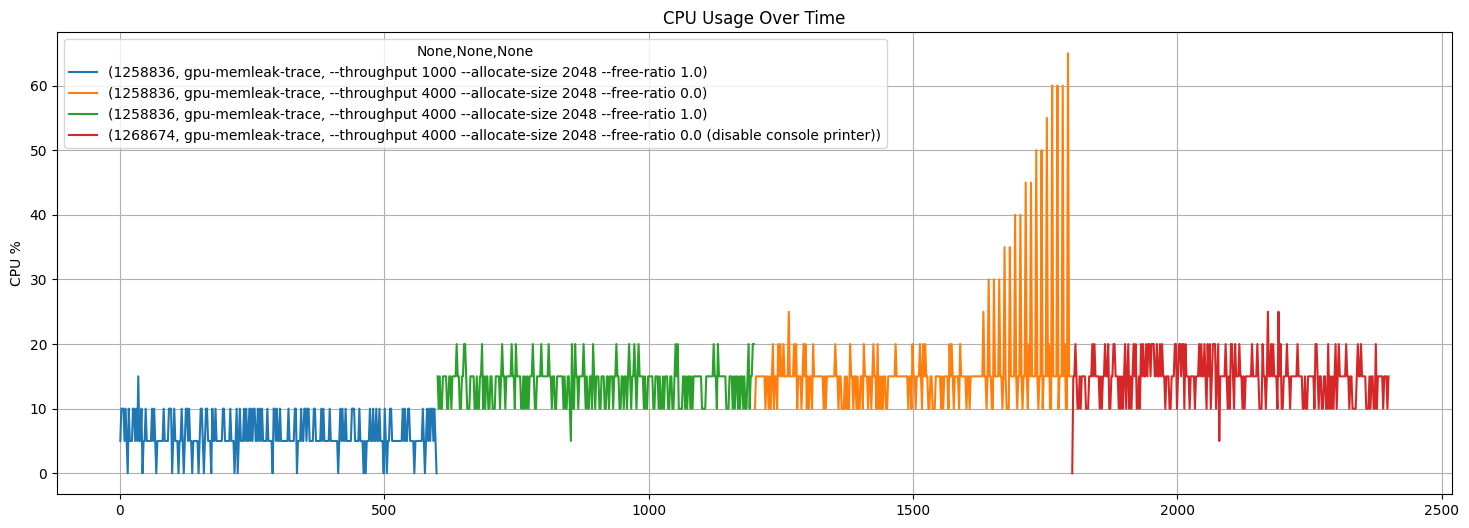

In [23]:
df.groupby(['pid', 'name', 'description'])['cpu_percent'].plot(figsize=(18, 6), grid=True, legend=True, ylabel='CPU %', title='CPU Usage Over Time')

It appears that the tool consumes a significant amount of CPU when trace results are printed to the console. (#TODO: performance optimization is needed).

This overhead occurs because, as more memory is stored in the map structure, the CPU must perform additional work to process the larger dataset. In this case, I have identified the Summary() and GetTopN() functions as the main contributors to the overhead. Further investigation and optimization will be performed in future iterations.

pid      name               description                                                                      
1258836  gpu-memleak-trace  --throughput 1000 --allocate-size 2048 --free-ratio 1.0                              Axes(0.125,0.11;0.775x0.77)
                            --throughput 4000 --allocate-size 2048 --free-ratio 0.0                              Axes(0.125,0.11;0.775x0.77)
                            --throughput 4000 --allocate-size 2048 --free-ratio 1.0                              Axes(0.125,0.11;0.775x0.77)
1268674  gpu-memleak-trace  --throughput 4000 --allocate-size 2048 --free-ratio 0.0 (disable console printer)    Axes(0.125,0.11;0.775x0.77)
Name: memory_mb, dtype: object

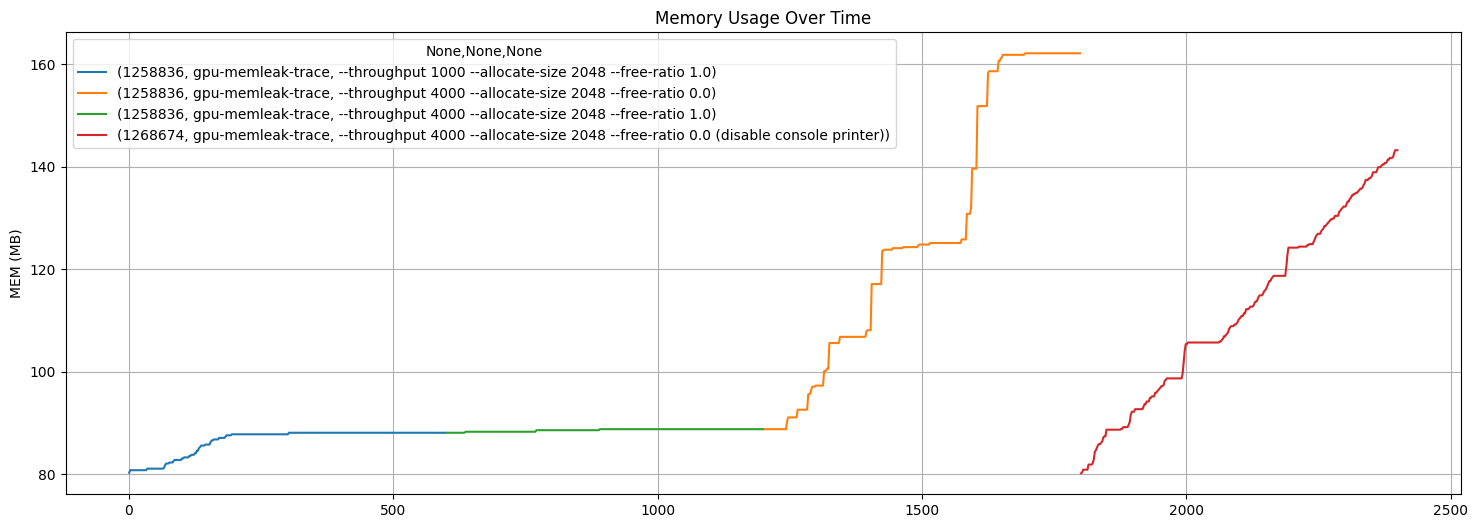

In [24]:
df.groupby(['pid', 'name', 'description'])['memory_mb'].plot(figsize=(18, 6), grid=True, legend=True, ylabel='MEM (MB)', title='Memory Usage Over Time')

In this result, let's consider each case:

- With a free ratio of 1.0, that means the tool does not need memory space to store leaked pointers, so memory usage will not increase significantly.
- With a free ratio of 0, the tool requires a data structure to store leaked pointers in memory, so memory usage will increase significantly. (#TODO: I will improve this later)

### Metrics report